In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import drawbox
%matplotlib inline

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from process import *
import mod

In [2]:
df = pd.read_csv('../samples/testing/ground_truth/noisy_large_slow_n.csv')

In [3]:
average_size = 0
for row in df.iterrows():
    average_size += (row[1][2] * row[1][3])
average_size /= len(df)
print(average_size)


81765.96890311324


In [3]:
for video in ['large5']:
    output = mod.run(
        yolov5_model='yolov5n',
        img_width=1280,
        img_height=720,
        fps=25,
        frame_cap=250,
        conf=0.6,
        video_path='../samples/testing/videos/',
        video_source=video,
        out_path=''
    )
    output.to_csv(f'./temp/{video}_n.csv')



Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


      xcenter     ycenter      width     height  confidence  class name
0  552.550659  607.211731  56.124512  58.999878    0.767848      2  car
1  647.667175  614.224854  74.165161  45.554077    0.695223      2  car
      xcenter     ycenter      width     height  confidence  class name
0  552.347900  606.835205  56.459229  59.727661    0.750483      2  car
1  647.365967  614.737000  74.356079  45.467651    0.645766      2  car
      xcenter     ycenter      width     height  confidence  class name
0  551.738892  606.618042  57.769531  60.716797    0.790721      2  car
1  647.581360  614.334534  77.478638  45.296509    0.681490      2  car
2  794.342529  615.622070  85.130127  55.051392    0.630383      2  car
      xcenter     ycenter      width     height  confidence  class name
0  551.325745  605.448486  59.235352  63.096313    0.814256      2  car
1  648.836182  613.763733  76.135010  46.978516    0.696954      2  car
2  793.879517  615.635620  87.265015  54.897827    0.666305     

In [2]:
drawbox.run('../samples/testing/ground_truth/large4_n.csv', '../samples/testing/ground_truth/large4_n.csv', '../samples/testing/videos/large4.mp4', './temp.mp4', False, None, 'None', None)

In [3]:
cap = cv2.VideoCapture('temp.mp4')
frame_no = 0
frame = None
while frame_no < 250:
    ret, frame = cap.read()
    if frame_no == 200:
        break
    frame_no += 1
    

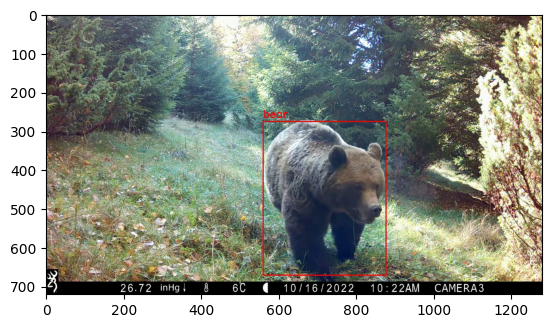

In [4]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA))

In [5]:
cv2.imwrite('temp.png', frame)

True

In [39]:
def process_inf(width, height, df, num_frames, get_gt):
    preds_list = []
    
    # Normalize values
    df.xcenter /= width
    df.ycenter /= df['ycenter'].div(height)

    # Loop through the frame numbers in df
    for i in range(1, num_frames+1):
        
        # Filter df for just the rows corresponding to current frame
        current_frame_df = df[df['frame'] == i]
        current_frame_df = current_frame_df.sort_values(by=['class', 'xcenter'], ascending=True)

        # Create FloatTensor containing boxes
        bbox_cols = current_frame_df[['xcenter', 'ycenter', 'width', 'height']]
        boxes = torch.tensor(bbox_cols.values)
        
        # Create IntTensor containing labels
        labels = torch.tensor(current_frame_df['class'].tolist())
                
        # Append dict with boxes, labels, and scores to the list
        if get_gt:
            frame_dict = {
                'boxes':boxes,
                'labels':labels
                }
        else:
            scores = torch.tensor(current_frame_df['confidence'].tolist())
            frame_dict = {
                'boxes': boxes,
                'labels': labels,
                'scores': scores
                }
             
        preds_list.append(frame_dict)
        
    return preds_list

def calculate_accuracy(ground_truth, prediction):
    metric = MeanAveragePrecision(box_format='cxcywh', iou_type="bbox")
    metric.update(prediction, ground_truth)
    result = metric.compute()
    return result['map'].item()
